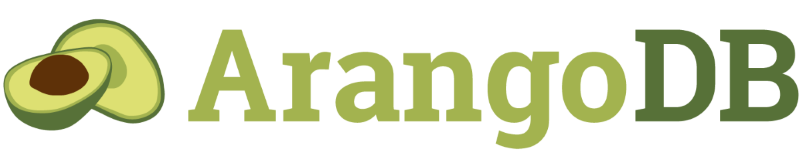

<a href="https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/arangoflix/recommend_movie_collaborative_filtering_aql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation Using AQL-based Collaborative Filtering
Recommendation using collaborative filtering implemented in AQL.  The algorithm computes recommendations dynamically given a User ID (user-a).  The query traverses from  user-a through rating edges to movies and then back to the other users uses and uses Cosine Simularity to determine the N most similar users (similar-group) to user-a.  Then the query traverses from the similar-group to through rate edges to movies to identify to identify the most highly rated movies of the similarity-group that have not been rated by user-a and returns this list as the recommendation.


#Setup Interactive Demo Environment

In [ ]:
%%capture
# !mkdir oasis
!mkdir data
!git clone -b movie-data https://github.com/arangodb/interactive_tutorials data
!git clone -b oasis_connector https://github.com/arangodb/interactive_tutorials oasis
!rsync -av oasis/ ./ --exclude=.git
!chmod -R 755 ./data
!chmod -R 755 ./tools
!chmod -R 755 ./oasis

##Instal ArangoDB Components

In [ ]:
%%capture
!pip install arangopipe==0.0.70.0.0
!pip3 install pyarango
!pip3 install python-arango

#Configure Connection to ArangoDB Database
You will be setting an ArangoDB temporary database and restoring the movie recommendation demo to it.  You can also set up an empty ArangoDB database instance in your own environement (Local, Cloud, or Oasis) and  restore the recommendation demo to it.  Or you can configure the connection to an existing arangodb instance containing the movie recommendation demo.

##Setup Temporary Database for Interactive Demo Environment

In [ ]:
import oasis

con = oasis.getTempCredentials(tutorialName="MovieRecommendations_AQL_Collaborative_Filtering")

# Connect to the temp database
conn = oasis.connect(con)
db = conn[con["dbName"]]
hostname = con["hostname"]
port = con["port"]
username = con["username"]
password = con["password"]
dbName = con["dbName"]

print()
print("https://{}:{}".format(con["hostname"], con["port"]))
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])

#Restore the Movie Knowledge Graph 

In [ ]:
%%capture
#Restore the Movie Knowledge Graph
! ./tools/arangorestore -c none --server.endpoint http+ssl://{hostname}:{port} --server.username {username} --server.database {dbName} --server.password {password} --include-system-collections true --replication-factor 3 --input-directory "./data/movie-knowledge-graph-dump-small"

#Run Collaborative Filtering Query

In [ ]:
import pandas as pd
import json
movieRecommendationQuery = """
              WITH Movie, User, rates
              LET similarUsers =
                (FOR movie, edge IN 1 OUTBOUND  @userId  rates  // eg. userid = Users/1 GRAPH 'movie-knowledge-graph'
                    LET userA_ratings = edge.rating //TO_NUMBER(edge.ratings)
                    FOR userB, edge2 IN 1..1 INBOUND movie rates
                        FILTER userB._id != @userId
                        LET userB_ratings = edge2.rating //TO_NUMBER(edge2.ratings)
                        COLLECT userids=userB._id INTO g KEEP userB_ratings, userA_ratings
                        LET userA_len   = SQRT(SUM (FOR r IN g[*].userA_ratings RETURN r*r))
                        LET userB_len   = SQRT(SUM (FOR r IN g[*].userB_ratings RETURN r*r))
                        LET dot_product = SUM (FOR n IN 0..(LENGTH(g[*].userA_ratings) - 1) RETURN g[n].userA_ratings * g[n].userB_ratings)
                        LET cos_sim = dot_product/ (userA_len * userB_len)
                        SORT cos_sim DESC LIMIT @similarUserLimit
                        RETURN {userBs: userids,
                              cosine_similarity: cos_sim}
                )
            LET userA_RatedMovies = (FOR movie, edge IN 1..1 OUTBOUND @userId rates RETURN movie._key)
            FOR userB in similarUsers
                FOR movie ,ratesEdge IN 1..1 OUTBOUND userB.userBs rates 
                    FILTER movie._key NOT IN userA_RatedMovies
                    COLLECT userA_UnratedMovie = movie
                    AGGREGATE ratingSum = SUM(ratesEdge.rating)  
                    SORT ratingSum DESC
                    LIMIT @movieRecommendationLimit
                    RETURN  {movie: userA_UnratedMovie, score : ratingSum} 
"""

bind = {'userId':'User/1', 'similarUserLimit': 10, 'movieRecommendationLimit':3}
movieData = db.AQLQuery(movieRecommendationQuery, rawResults=True, bindVars=bind)
movieDataFrame = pd.DataFrame.from_dict(movieData)
movieDataFrame.head(10)